# <font color=blue>Datathon  </font>
## UniversityHack - Cajamar 2020

## Reto: Minsait Land Classification

**Diseño y uso de un modelo de inteligencia artificial resolver el problema de clasificación multiclase qur propone el reto Minsait Land Classification**

**Objetivo**: encontrar mejor modelo de clasificación automática de suelos en base a las imágenes proporcionadas por el satélite Sentinel II del servicio Copernicus de la Agencia Espacial Europea y otras variables relativas a las características de la parcela y su entorno.

**Valoración**: 

- La calidad y la técnica utilizada para generar un modelo


- Se analizará la técnica analítica utilizada y se compararán objetivamente los valores reales frente a los valores predichos por el modelo. La métrica para maximizar es la “precisión”.


- Que la documentación interna aportada (códigos, comentarios) esté correctamente expresada y estructurada, y sea reproducible. 

- En la Fase de Presentación de mejores trabajos, el Jurado tendrá en cuenta que el modelado y los resultados obtenidos se transmitan de forma clara y concisa.




### Preludio: Importamos las librerías necesarias

In [4]:
# Liberías necesarias para la manipulación de datos
import os
import numpy as np
import pandas as pd
import joblib

#Librerías de plotting:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

#Librerías de procesamiento de datos
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer, OneHotEncoder

#Liberías de metrica de evaluación
from sklearn.metrics import confusion_matrix, accuracy_score, balanced_accuracy_score, average_precision_score, f1_score, precision_score, recall_score, jaccard_score
    
#Modelos de Machine Learning
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
# from xgboost import XGBClassifier

#Desactivamos los avisos de Jupyter Notebook:
import warnings
warnings.filterwarnings('ignore')

### Estructura del Proyecto:

**1. Carga y análisis exploratorio de los datos**
    - 1.1. Carga de los datasets
    - 1.2. Estadísticas básicas
    - 1.3. Escalado, limpieza y edición de las variables
    - 1.4. Visualización de la distribución en el plano 2D
    - 1.5. Análisis y selección de variables
    
    
**2.  Generación de variables sintéticas**

    

**3. Resampling de datos**
    - 3.1. Búsqueda de la mejor estrategia de resampleo
    - 3.2. Generación y guardado del mejor resampleado
    
    
**4. Construcción, entreno del modelo**
    - 4.1. Selección de modelos
    - 4.2. Stacking
    

**5. Evaluación del modelo y guardado del modelo**



**6. Script de clasificación** 
    - 6.1. Construcción de la arquitectura del clasificador
    - 6.2. Generación del dataset de test
    

**7. Retos futuros**



## **1. Carga y análisis exploratorio de los datos**

**¿En que consiste el Dataset?**

EL dataset contiene un total 55 variables de diversas índoles y una 1 variable 'CLASE', objeto de clasifiación: 

- Las 3 primeras relativas a la identificación registral y coordenadas geográficas (anonimizadas). 


- Las 44 siguientes están conformadas por la información extraída y tratada de las imágenes satelitales mediante 4 canales (R, G, B y NIR), correspondientes a las bandas de color rojo, verde y azul, y el infrarrojo cercano. El valor mostrado corresponde a la intensidad por deciles en cada imagen. Estas variables empiezan con la letra “Q” y disponen de 11 variables para cada cada canal que representan los deciles de densidad del canal.


- Las 8 últimas variables son distintas referencias geométricas relativas a la parcela/edificio (geometría y superficie del edificio, y del entorno de la misma (año construcción y nº de plantas de los edificios colindantes).


- La última variable es la clase a predecir (únicamente en el fichero de entreno), que dispone de 7 categorías distintas, que son las siguientes:


**CLASES:**
 - RESIDENTIAL
 - INDUSTRIAL
 - OFFICE
 - PUBLIC
 - AGRICULTURE
 - RETAIL
 - OTHER



###  1.1. Carga de los datasets:

In [2]:
#Datos que definimos:
TRAIN_FILE_NAME = 'Modelar_UH2020.txt'
PATH = './Datasets/'

#Carga de los ficheros de entreno:
data_train = pd.read_csv(PATH + TRAIN_FILE_NAME, sep='|')

Descomponemos el dataset en secciones útiles para analizar:

In [3]:
id_data = data_train.iloc[:,0] #Código alfanumérico que no coincide con una referencia catastral

x_y_data = data_train.iloc[:,1:3] #Coordenadas de los centroides de las fincas

rgb_data = data_train.iloc[:,3:36] #Datos de los colores RGB: -tamaño: 103230 * 33-

nir_data = data_train.iloc[:,36:47] #Datos de los frecuencias NIR: -tamaño: 103230 * 11-

polygon_data = data_train.iloc[:,[47,48,49,50,51]] #Datos del área (m2) y la forma del polígono de la finca

environment_data = data_train.iloc[:,[52,53,54]] #Datos del entorno de la parcela 

class_data = data_train.iloc[:,[55]] #Datos referentes a los tipos de fincas

### 1.2. - Estadísticas básicas del dataset:

In [5]:
print('Tipo de dato para cada categoría: ')
print('---------------------------------')
data_train.dtypes

Tipo de dato para cada categoría: 
---------------------------------


ID                     object
X                       int64
Y                       int64
Q_R_4_0_0             float64
Q_R_4_0_1             float64
Q_R_4_0_2             float64
Q_R_4_0_3             float64
Q_R_4_0_4             float64
Q_R_4_0_5             float64
Q_R_4_0_6             float64
Q_R_4_0_7             float64
Q_R_4_0_8             float64
Q_R_4_0_9             float64
Q_R_4_1_0             float64
Q_G_3_0_0             float64
Q_G_3_0_1             float64
Q_G_3_0_2             float64
Q_G_3_0_3             float64
Q_G_3_0_4             float64
Q_G_3_0_5             float64
Q_G_3_0_6             float64
Q_G_3_0_7             float64
Q_G_3_0_8             float64
Q_G_3_0_9             float64
Q_G_3_1_0             float64
Q_B_2_0_0             float64
Q_B_2_0_1             float64
Q_B_2_0_2             float64
Q_B_2_0_3             float64
Q_B_2_0_4             float64
Q_B_2_0_5             float64
Q_B_2_0_6             float64
Q_B_2_0_7             float64
Q_B_2_0_8 

Como podemos observar, habrá que manipular las variables CADASTRALQUALITYID y CLASE dado que cuentienen strings y para el entreno de modelos necesitamos lidiar con valores numéricos.

In [5]:
print('Número de clases de cada tipo:')
print(data_train.groupby(data_train.CLASE).count()['ID'])
print('-----------------------')
print('Proporción (%) de clases de cada tipo:')
print(data_train.groupby(data_train.CLASE).count()['ID']/data_train.CLASE.count()*100)

Número de clases de cada tipo:
CLASE
AGRICULTURE      338
INDUSTRIAL      4490
OFFICE          1828
OTHER           1332
PUBLIC          2976
RESIDENTIAL    90173
RETAIL          2093
Name: ID, dtype: int64
-----------------------
Proporción (%) de clases de cada tipo:
CLASE
AGRICULTURE     0.327424
INDUSTRIAL      4.349511
OFFICE          1.770803
OTHER           1.290323
PUBLIC          2.882883
RESIDENTIAL    87.351545
RETAIL          2.027511
Name: ID, dtype: float64


Como podemos ver, hay una divergencia en las proporciones de las distintas clases en el dataset. Observamos que de la clase Residential es de donde proceden el 87.35% de las muestras del dataset.


Esto provoca que los modelos de machine learning que quieran aplicarse para captar los patrones que esconden los datos de cada una de las clases tengan dificultad a la hora de aprender sobre los patrones de las clases menores dado que estan infrarepresentados.

Por ello será necesario aplicar una estrategia de resampling sobre los datos de manera que balenceemos el conjunto de datos que tenemos para que el modelo que acabemos aplicando pueda aprender mejor en el entreno, y consecuentemente haga mejores clasificaciones al reconocer bien las clases minoritarias.

In [6]:
print('MISSING VALUES ANALYSIS:')
print('---------------------------')
print(data_train.isna().sum())
print('---------------------------')
print('Número total de NaNs: ', data_train.isna().sum().sum())

MISSING VALUES ANALYSIS:
---------------------------
ID                     0
X                      0
Y                      0
Q_R_4_0_0              0
Q_R_4_0_1              0
Q_R_4_0_2              0
Q_R_4_0_3              0
Q_R_4_0_4              0
Q_R_4_0_5              0
Q_R_4_0_6              0
Q_R_4_0_7              0
Q_R_4_0_8              0
Q_R_4_0_9              0
Q_R_4_1_0              0
Q_G_3_0_0              0
Q_G_3_0_1              0
Q_G_3_0_2              0
Q_G_3_0_3              0
Q_G_3_0_4              0
Q_G_3_0_5              0
Q_G_3_0_6              0
Q_G_3_0_7              0
Q_G_3_0_8              0
Q_G_3_0_9              0
Q_G_3_1_0              0
Q_B_2_0_0              0
Q_B_2_0_1              0
Q_B_2_0_2              0
Q_B_2_0_3              0
Q_B_2_0_4              0
Q_B_2_0_5              0
Q_B_2_0_6              0
Q_B_2_0_7              0
Q_B_2_0_8              0
Q_B_2_0_9              0
Q_B_2_1_0              0
Q_NIR_8_0_0            0
Q_NIR_8_0_1           

Las variables MAXBUILDINGFLOOR y CADASTRALQUALITYID tienen 20 valores omitidos (40 en total).


Vamos en que clases tienen los datos faltantes

In [7]:
print("NAs de 'CADASTRALQUALITYID':")
print(data_train[data_train['CADASTRALQUALITYID'].isna()].groupby(data_train.CLASE).count()['CLASE'])
print("----------------------------")
print("NAs de 'MAXBUILDINGFLOOR':")
data_train[data_train['MAXBUILDINGFLOOR'].isna()].groupby(data_train.CLASE).count()['CLASE']

NAs de 'CADASTRALQUALITYID':
CLASE
AGRICULTURE    15
INDUSTRIAL      4
RETAIL          1
Name: CLASE, dtype: int64
----------------------------
NAs de 'MAXBUILDINGFLOOR':


CLASE
AGRICULTURE    15
INDUSTRIAL      4
RETAIL          1
Name: CLASE, dtype: int64

Como podemos ver, faltan valores en las mismas 20 clases, por lo que deberíamos tratar estas 20 clases eliminándolas o bien, rellenando este valor por un valor nulo u otro valor que refleje las característica de la variable omitida.

### Análisis de las variables:

#### Análisis de rangos de las coordenadas X,Y:

In [8]:
print('-----Características Geográficas------')
min_values = pd.DataFrame(x_y_data.min(), columns=['Valores mínimos'])
max_values = pd.DataFrame(x_y_data.max(), columns=['Valores máximos'])
max_min_df = pd.concat([min_values, max_values], axis=1,).T
print(max_min_df)

-----Características Geográficas------
                          X          Y
Valores mínimos  2120750954  165095665
Valores máximos  2287300421  166504639


#### Análisis de e las dimensiones del área de las fincas:

In [9]:
print('---------------------Características Geométricas-----------------------')
min_values = pd.DataFrame(polygon_data.min(), columns=['Valores mínimos'])
max_values = pd.DataFrame(polygon_data.max(), columns=['Valores máximos'])
max_min_df = pd.concat([min_values, max_values], axis=1,).T
print(max_min_df)

---------------------Características Geométricas-----------------------
                          AREA   GEOM_R1   GEOM_R2   GEOM_R3    GEOM_R4
Valores mínimos       0.038770  0.000626  0.000679  0.000770   0.015157
Valores máximos  238058.952253  1.000000  1.785714  2.631579  68.812431


#### Análisis de rangos de las variables RGB:

In [10]:
print('--------------------Rangos RGB----------------------')
min_values = pd.DataFrame(rgb_data.min(), columns=['Valores RGB mínimos'])
max_values = pd.DataFrame(rgb_data.max(), columns=['Valores RGB máximos'])
max_min_df = pd.concat([min_values, max_values], axis=1,)
print(max_min_df)

--------------------Rangos RGB----------------------
           Valores RGB mínimos  Valores RGB máximos
Q_R_4_0_0             0.000000             1.016050
Q_R_4_0_1           151.000375           833.999402
Q_R_4_0_2           184.999420          1016.000732
Q_R_4_0_3           214.000473          1200.003003
Q_R_4_0_4           239.999503          1377.999927
Q_R_4_0_5           269.999451          1570.504517
Q_R_4_0_6           310.999493          1806.002686
Q_R_4_0_7           382.999844          2175.694824
Q_R_4_0_8           459.001373          2575.792188
Q_R_4_0_9           591.000671          2940.000635
Q_R_4_1_0          2337.124724         16316.530592
Q_G_3_0_0             0.000000            51.002148
Q_G_3_0_1           215.999632           720.000836
Q_G_3_0_2           274.000061           885.999023
Q_G_3_0_3           298.999237          1057.998584
Q_G_3_0_4           324.999908          1240.000488
Q_G_3_0_5           364.998383          1374.999939
Q_G_3_0_6  

Vemos que para cada color RGB, los valores se mueven en el mismo rango global, aunque con distinta distribución, siempre creciente relativamente al número de variable.

Se procederá a normalizar las variables entre 0 y uno en relación al mínimo y máximo global debido al desconocimiento de los límites reales.

### Análisis de rangos de las variables NIR:

In [11]:
print('---------------------Rangos NIR-----------------------')
min_values = pd.DataFrame(nir_data.min(), columns=['Valores NIR mínimos'])
max_values = pd.DataFrame(nir_data.max(), columns=['Valores NIR máximos'])
max_min_df = pd.concat([min_values, max_values], axis=1,)
print(max_min_df)

---------------------Rangos NIR-----------------------
             Valores NIR mínimos  Valores NIR máximos
Q_NIR_8_0_0             0.000000           434.014923
Q_NIR_8_0_1           328.703671          2055.998657
Q_NIR_8_0_2           700.003967          2324.008301
Q_NIR_8_0_3           914.001007          2579.501465
Q_NIR_8_0_4          1099.995972          2801.996582
Q_NIR_8_0_5          1264.005249          2983.994995
Q_NIR_8_0_6          1435.997559          3158.000488
Q_NIR_8_0_7          1632.993774          3408.002808
Q_NIR_8_0_8          1861.006226          3750.997559
Q_NIR_8_0_9          2172.992676          4614.998535
Q_NIR_8_1_0          4085.049076         15848.608811


Igualmente vemos que para las variables de las ondas NIR, los valores se mueven en un rango global similar aunque no igual a las RGB (con un máximo global inferior), siempre creciente relativamente al número de variable.


También se procederá a normalizar las variables entre 0 y uno en relación al mínimo y máximo global debido al desconocimiento de los límites reales.


### 1.3. Escalado, limpieza y edición de las variables

Aunque el dataset ya viene bastante limpio, así como hemos observado en el análisis exploratiorio previo, hará falta estandarizar la escala, tratar con los valores omitidos y retocar ciertas variables como son CONTRUCTIONYEAR, MAXBUILDINGFLOOR, CADASTRALQUALITYID, para que se compongan exclusivamente de valores numéricos y reflejen mejor la explicatividad sobre la variable clasificar, con el objetivo de que sean adaptables a los algoritmos de machine learning.



#### Escalado (Estandarización / Normalización): 
Como hemos observado que las variables relativas a los declies de intensidad de NIR y RGB valores no homogéneos entre ellos, vamos a proceder a escalarlos restando la media y proporcionando a la desviación estándar para que sean más procesables para nuestros algoritmos:

**RGB**

Escalamos los canales RGB por separado

In [6]:
#Separamos los canales
red_data = rgb_data.iloc[:,:11]
green_data = rgb_data.iloc[:,11:22]
blue_data = rgb_data.iloc[:,22:33]

#Escalamos cada canal por separado
red_data = (red_data - red_data.mean()) / red_data.std()
green_data = (green_data - green_data.mean()) / green_data.std()
blue_data = (blue_data - blue_data.mean()) / blue_data.std()

#Reunificamos los canales en rgb_data
rgb_data = pd.concat([red_data, green_data], axis = 1,)
rgb_data = pd.concat([rgb_data, blue_data], axis = 1,)

**NIR**

In [7]:
nir_data = (nir_data - nir_data.mean()) / nir_data.std()

#### Limpieza (tratamiento de valores omitidos NAs):

**MAXBUILDINGFLOOR**


Debido a que la clases agraria es la que tiene más valores faltantes en esta variable y representan un 9% del número total de muestras de esta clase, en vez de eliminarlas, preferimos transformar los valores NaN de MAXBUILDINGFLOOR en 0, ya que la intuición nos dice que la finca no tienen plantas, debido a que son terrenos agrónomos:


In [10]:
environment_data.loc[:,'MAXBUILDINGFLOOR'] = environment_data['MAXBUILDINGFLOOR'].fillna(0)

**CADASTRALQUALITYID**


Debido a que los valores de esta variable representan un valor categórico ordinal (por ejemplo, el rango económico de valoración), vamos a tratarlas como si todos los valores omitidos fueran de una clase concreta (son homogéneos entre ellos), a falta de otra intuición por falta de conocimiento sobre le procedencia de esta omisión. 


Por ello vamos a transformar los NAs en la variable numérica 0, dentro de la escala ya existente de CADASTRALQUALITYID:

In [9]:
environment_data.loc[:,'CADASTRALQUALITYID'] = environment_data['CADASTRALQUALITYID'].fillna('0')

#### Edición de variables:

**CONTRUCTIONYEAR**


Transformamos los valores del año (cuyo valor absoluto no es demasiado explicativo, ya que la mayoría de construcciones son de años recientes a la actualidad), a valores que representen los años que han pasado desde la construcción hasta la fecha del dataset, con el objetivo de que refleje con mayor nitidez el efecto del transcurso de los años, en el caso de que éste fuera explicativo para la clasificación del tipo de finca:


In [11]:
environment_data.loc[:,'CONTRUCTIONYEAR'] = environment_data['CONTRUCTIONYEAR'].max() - environment_data['CONTRUCTIONYEAR']

**CADASTRALQUALITYID**


Transformamos la variable CADASTRALQUALITYID en numeros del 0 al 12, teniendo en cuenta que existe un órden: 

{Nan < A < B < C < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9}

           lo transformamos en:

{0 < 1 < 2 < 3 < 4 < 5 < 6 < 7 < 8 < 9 < 10 < 11 < 12}




In [12]:
environment_data.loc[:,'CADASTRALQUALITYID'] = environment_data['CADASTRALQUALITYID'].replace({"A": '1', "B": '2', "C": '3', 1: '4', 2: '5', 3: '6', 4: '7', 5: '8', 6: '9', 7: '10', 8: '11', 9: '12'}).astype(np.int64)

**CLASE**


Al ser la variable CLASE de tipo categórico, también deberemos tratar de transformarla en valores numéricos para que los algoritmos puedan inferir sobre ella. Parece ser una variable categórica que no representa grados ni relaciones, por lo que un numero entero cardinal va a ser suficiente para reflejar su contenido.

Transformaremos el dataframe de clases en enteros siguiendo la siguiente relación y lo llamaremos 'transformed_class':

 - "RESIDENTIAL": 0
 - "INDUSTRIAL":  1 
 - "OFFICE":      2 
 - "PUBLIC":      3 
 - "AGRICULTURE": 4 
 - "RETAIL":      5
 - "OTHER":       6



In [13]:
#Transformamos la variable CLASE en valores enteros del 0 al 6 (según la categoría):
transform_data = pd.DataFrame(class_data)
transform_data['CLASS_VALUE'] = class_data.replace({"RESIDENTIAL": 0, 
                                                    "INDUSTRIAL": 1, 
                                                    "OFFICE": 2, 
                                                    "PUBLIC": 3, 
                                                    "AGRICULTURE": 4, 
                                                    "RETAIL": 5, 
                                                    "OTHER": 6})

transformed_class = pd.DataFrame(transform_data['CLASS_VALUE'])

#### Creamos el dataframe
Juntamos todas las piezas que hemos ido editanto hasta ahora en un solo DataFrame al que llamaremos 'data':

In [14]:
#Unión del Dataset de entreno editado (shape: 103230 x 70):
data = id_data
data = pd.concat([data, x_y_data], axis = 1,)
data = pd.concat([data, rgb_data], axis = 1,)
data = pd.concat([data, nir_data], axis = 1,)
data = pd.concat([data, polygon_data], axis = 1,)
data = pd.concat([data, environment_data], axis = 1,)
data = pd.concat([data, transformed_class], axis = 1,)

Comprobamos que todos son datos numéricos (a excepción de la 'ID' que no tiene significancia estadística):

In [15]:
data.dtypes

ID                     object
X                       int64
Y                       int64
Q_R_4_0_0             float64
Q_R_4_0_1             float64
Q_R_4_0_2             float64
Q_R_4_0_3             float64
Q_R_4_0_4             float64
Q_R_4_0_5             float64
Q_R_4_0_6             float64
Q_R_4_0_7             float64
Q_R_4_0_8             float64
Q_R_4_0_9             float64
Q_R_4_1_0             float64
Q_G_3_0_0             float64
Q_G_3_0_1             float64
Q_G_3_0_2             float64
Q_G_3_0_3             float64
Q_G_3_0_4             float64
Q_G_3_0_5             float64
Q_G_3_0_6             float64
Q_G_3_0_7             float64
Q_G_3_0_8             float64
Q_G_3_0_9             float64
Q_G_3_1_0             float64
Q_B_2_0_0             float64
Q_B_2_0_1             float64
Q_B_2_0_2             float64
Q_B_2_0_3             float64
Q_B_2_0_4             float64
Q_B_2_0_5             float64
Q_B_2_0_6             float64
Q_B_2_0_7             float64
Q_B_2_0_8 

Lo guardamos como 'Data_UH2020.txt' por si hiciera falta más tarde o para poderlo cargar sin tenerlo siempre almacenado en RAM:

In [16]:
RESULT_FILE_NAME = 'Data_UH2020.txt'
data.to_csv(PATH + RESULT_FILE_NAME, sep='|', index_label=False)
print('-- Guardado con éxito! --')

-- Guardado con éxito! --


### 1.4. Visualización de la distribución de los datos geográficos en el plano 2D


Ya que estamos tratando con variables geográficas, para hacernos una mejor idea de la distribución de las clases según su ubicación geográfica, vamos a representarlas por colores (según clase) sobre un plano 2D. 

Dado que los centroides de las coordenadas han sido desplazadas de su ubicación original, no podemos representralas sobre un mapa real, aunque si se mantiene la distancia relativa entre los puntos, por lo que la figura que representa el gráfico de dispersión de los puntos es real.

Debido a la forma de la distribución de los puntos y por la información proporcionada en la descripción del reto, sabemos que la localización corresponde al centro de Madrid:

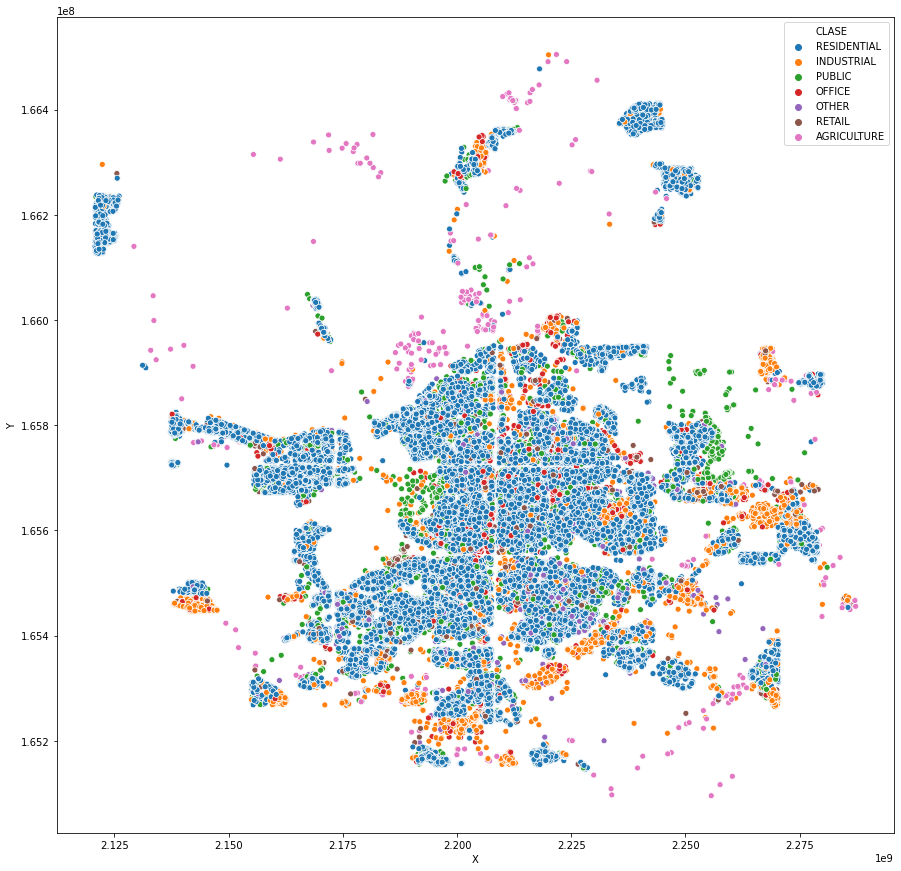

In [22]:
df = pd.concat([x_y_data, class_data], axis=1,)

plt.figure(figsize=(15, 15))
plot = sns.scatterplot(x=df.X, y=df.Y, hue=df.CLASE)

Según lo que podemos observar en el mapa:

La mayoría de muestras son de **viviendas** (azul), situadas en el centro del mapa y con una densidad muy elevada entre ellas. 


Las **indústrias** (naranja) se encuentran mayoritariamente concentradas entre ellas en polígonos de la zona periférica del mapa.


Los **edificios públicos** (verde) se encuentran dispersos por toda la zona central del mapa y adicionalmente concentrados en distintas ubicaciones.

Las **oficinas** (rojo) están más dispersas pero únicamente en la zona central del mapa.

Las **fincas agrarias** (rosa) se encuentran en su mayoría en el extrarradio del mapa.

Las **tiendas** (marrón) y la clase **'otros'** (violeta) no responden a un perfil específico y se encuentran dispersas por todo el mapa, con más influencia en el centro del mismo.


### 1.5. Análisis y selección de variables

Primero de todo, instanciamos la sección de variables explicativas del dataset generado 'data' en la variable 'X' y la variable 'CLASS_VALUE' (la transformación a entero de la variable a classificar) en 'y'.


Dejaremos la variable 'ID' al mérgen, debido a su falta de explicatividad al ser un mero índice catastral:

In [17]:
X = data.iloc[:, 1:-1]
y = data.iloc[:, -1:]

#### Análisis de importancia de las variables

Mediante el uso de un 'ExtraTreesClassifier' (un algoritmo del tipo ensemble basado en bosques aleatorios), vamos a asignar el porcentaje de importancia de cada una de las variables 'X' en relación a su efecto sobre la variable 'y' a clasificar y vamos a ordenarla en sentido decreciente:

In [18]:
# Construimos el modelo y calculamos la importancia de cada una de las variables explicativas:
forest = ExtraTreesClassifier(n_estimators=100, random_state=2020)
forest.fit(X, y)
importancia = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importancia)[::-1]

#Mostrar ránking de relevancia
print("RÁNKING DE IMPORTANCIA DE LAS 'X':")
print('')
for atributo in range(X.shape[1]):
    print("%d. %s: %f" % (atributo + 1, X.columns[indices[atributo]], importancia[indices[atributo]]*100)+"%")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


RÁNKING DE IMPORTANCIA DE LAS 'X':

1. AREA: 11.547937%
2. GEOM_R2: 10.112713%
3. GEOM_R3: 9.971980%
4. X: 8.721095%
5. GEOM_R1: 8.516367%
6. Y: 8.318529%
7. GEOM_R4: 7.265603%
8. MAXBUILDINGFLOOR: 6.753019%
9. CONTRUCTIONYEAR: 6.509921%
10. CADASTRALQUALITYID: 5.373049%
11. Q_B_2_0_9: 0.982254%
12. Q_B_2_0_8: 0.847551%
13. Q_B_2_0_7: 0.558934%
14. Q_B_2_0_5: 0.537505%
15. Q_G_3_0_8: 0.524548%
16. Q_B_2_0_2: 0.487732%
17. Q_G_3_0_9: 0.478643%
18. Q_R_4_0_1: 0.461907%
19. Q_B_2_0_6: 0.442813%
20. Q_B_2_0_1: 0.413395%
21. Q_G_3_0_1: 0.403073%
22. Q_NIR_8_0_1: 0.394378%
23. Q_NIR_8_0_9: 0.392366%
24. Q_B_2_1_0: 0.390535%
25. Q_B_2_0_3: 0.389166%
26. Q_B_2_0_4: 0.374913%
27. Q_G_3_0_7: 0.373249%
28. Q_R_4_0_8: 0.367570%
29. Q_NIR_8_0_0: 0.357916%
30. Q_G_3_0_6: 0.356312%
31. Q_G_3_0_0: 0.351095%
32. Q_R_4_0_6: 0.349963%
33. Q_R_4_0_9: 0.343353%
34. Q_NIR_8_0_7: 0.339713%
35. Q_NIR_8_0_2: 0.339257%
36. Q_R_4_0_5: 0.335523%
37. Q_NIR_8_0_5: 0.333077%
38. Q_G_3_0_2: 0.328764%
39. Q_NIR_8_0_3:

Grafiquemos la importancia porcentual de cada una de las variables explicativas:

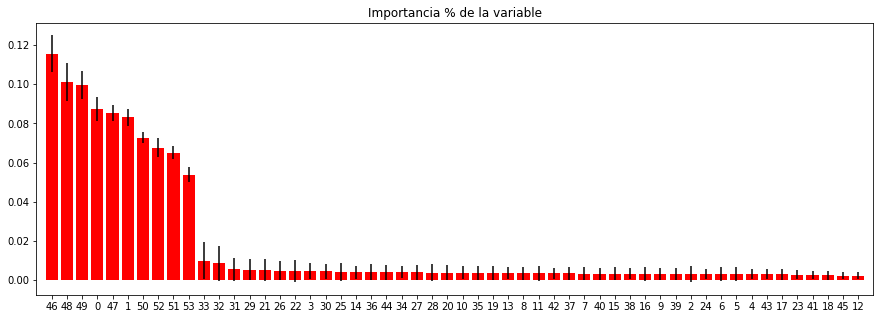

In [25]:
plt.figure(figsize=[15,5])
plt.title("Importancia % de la variable")
plt.bar(range(X.shape[1]), importancia[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Vemos que hay 10 variables que tiene mucha importancia a la hora de hacer una clasificación correcta de la variable CLASE: son las variables que tienen que ver con la ubicación geográfica y las características catastrales y periféricas de la parcela. Sin embargo las variables NIR y RGB, si bien tienen una buena significatividad conjunta, el efecto individual es mínimo, por lo que vendría bien transformarlas y reducir su dimensionalidad (para aumentar la significatividad individual, reduciendo el consumo de recursos de procesamiento).

### 2.  Generación de variables sintéticas

Vamos a tratar de enriquecer el dataset añadendo a las variables que vienen en el Dataset de train dalgunas variables nuevas:


 - Una variable numérica que representa el cuadrante en que se encuentra la coordenada de la muestra, que se genera mediante una clusterización de las coordenadas mediante el algoritmo kmeans que se basa en la agrupación de dichas localizaciones.
 
 
 - Trece variables numéricas de los Componentes Principales que representan el 99% de la explicatividad sobre la clase a predecir de los valores RGB y NIR.

#### Mapa de cuadrantes geográficos

Debido a que la información que dan las variables X e Y es significante en relación a su posición relativa y no de manera absoluta (ya que estan movidas del mapa original), creamos una variable sintetica que divide los limites del mapa en tantos cuadrados uniformes como le digamos que encapsulan aquellas fincas en las ubicaciones X,Y que son cercanas, de manera que discretizamos la posición del cuadro donde se encuentran las fincas relativamente a las demás:

In [19]:
# Cargamos y mostramos el dataset de coordenadas X,Y
random_state = 2020
X_list = [x_y_data.to_numpy()]
i = 1
for ds_cnt, X_Y in enumerate(X_list):
    i += 1
    
#Discretizamos las coordenadas agrupandolas en cuadrantes y devuelve las coordenadas de los cuadrantes:
discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
transformed_X_Y = pd.DataFrame(discretizer.fit_transform(X_Y), columns=['X_discr', 'Y_discr'])

#Convierte las coordenadas de los cuadrantes en un solo integro que representa cada uno de los cuadrantes creados:
X_Y_location = []
for coord in transformed_X_Y.values:
    position = str(int(coord[0]))+str(int(coord[1]))
    X_Y_location.append(position)
transformed_X_Y_location = pd.DataFrame(X_Y_location, columns=['X_Y_quadrant'])

#Transforma los anteriores integros no correlativos en correlativos ordinales
le = LabelEncoder()
le.fit(X_Y_location)
quadrant_num_data = pd.DataFrame(le.transform(X_Y_location), columns=['Quadrant_num'])

#### Principal Component Analysis

Ya que las variables RGB y NIR no son significativamente importantes y cargan mucho el procesamiento, las vamos a descomponer a su transformación en los componentes principales que representen el 99% de la explicatividad que tienen en relación a la variable a clasificar:

In [20]:
#Normalizamos los datos conjuntos
escalador = StandardScaler()
rgb_nir_data = pd.concat([rgb_data, nir_data], axis = 1,)
escalador.fit(rgb_nir_data)
X_escalado = escalador.transform(rgb_nir_data)

#Generamos y aplicamos el PCA
pca = PCA(.99)
pca.fit(X_escalado)
X_pca = pca.transform(X_escalado)
n_components = X_pca.shape[1]
pca_data = pd.DataFrame(X_pca)

#### Red Neuronal Convolucional 1D para las capas NIR y RGB


Se pretende crear un red que procese los vectores NIR y RGB de manera paralela para interpretar los patrones significativos de los percentiles de intensidad que hay en las imágenes y cuya predicción sea otra de las variables que enriquecen el dataset que procesará el modelo último que se aplica.

In [ ]:
-- En PROCESO --

#### Creación del nuevo dataset

Enriquecemos el dataset 'data' con las nuevas variables creadas para aumentar el rendimiento de los algortimos para la clasificación correcta de la clase:

    - Se añade la variable 'Número del cuadrante': grid de 50x50 que ubica X e Y de forma uniforme
    - Se añaden 13 variables con los componentes principales de las variables RGB y NIR demanera conjunta
    - Se omiten las variables RGB-NIR

In [21]:
#Unión del Dataset de entreno editado (shape: 103230 x 70):
new_data = id_data
new_data = pd.concat([new_data, x_y_data], axis = 1,)
new_data = pd.concat([new_data, quadrant_num_data], axis = 1,)
new_data = pd.concat([new_data, pca_data], axis = 1,)
new_data = pd.concat([new_data, polygon_data], axis = 1,)
new_data = pd.concat([new_data, environment_data], axis = 1,)
new_data = pd.concat([new_data, transformed_class], axis = 1,)

Guardamos el nuevo dataset enriquecido con variables sintéticas en el fichero 'New_Data_UH2020.txt':

In [22]:
NEW_FILE_NAME = 'New_Data_UH2020.txt'
data.to_csv(PATH + NEW_FILE_NAME, sep='|', index_label=False)
print('-- Guardado con éxito! --')

-- Guardado con éxito! --


#### Analisis de importancia de las variables del nuevo dataset enriquecio 'new_data'

In [23]:
new_X = new_data.iloc[:, 1:-1]
new_y = new_data.iloc[:, -1:]

In [31]:
# Construimos el modelo y calculamos la importancia de cada una de las variables explicativas:
forest = ExtraTreesClassifier(n_estimators=100, random_state=2020)
forest.fit(new_X, new_y)
importancia = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importancia)[::-1]

#Mostrar ránking de relevancia
print("RÁNKING DE IMPORTANCIA DE LAS 'X':")
print('')
for atributo in range(new_X.shape[1]):
    print("%d. %s: %f" % (atributo+1, new_X.columns[indices[atributo]], importancia[indices[atributo]]*100)+"%")

RÁNKING DE IMPORTANCIA DE LAS 'X':

1. AREA: 10.604864%
2. GEOM_R3: 9.432035%
3. GEOM_R2: 9.361038%
4. GEOM_R1: 7.909478%
5. Y: 7.755339%
6. X: 7.681616%
7. GEOM_R4: 6.492138%
8. MAXBUILDINGFLOOR: 6.203528%
9. CONTRUCTIONYEAR: 5.828371%
10. Quadrant_num: 5.615250%
11. CADASTRALQUALITYID: 5.034696%
12. 6: 1.932122%
13. 3: 1.679153%
14. 0: 1.573044%
15. 1: 1.452676%
16. 5: 1.429273%
17. 12: 1.402690%
18. 10: 1.387788%
19. 11: 1.362412%
20. 4: 1.222127%
21. 9: 1.218782%
22. 8: 1.174046%
23. 7: 1.141881%
24. 2: 1.105651%


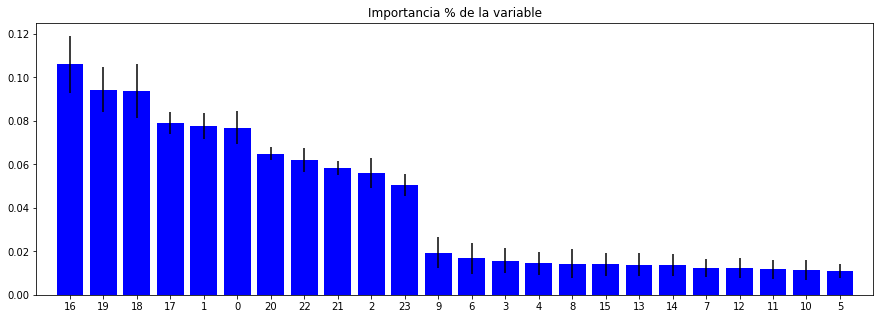

In [32]:
plt.figure(figsize=[15,5])
plt.title("Importancia % de la variable")
plt.bar(range(new_X.shape[1]), importancia[indices], color="b", yerr=std[indices], align="center")
plt.xticks(range(new_X.shape[1]), indices)
plt.xlim([-1, new_X.shape[1]])
plt.show()

Como comprobamos, hemos conseguido mantener la explicatividad del modelo, reduciendo el numero de variables a menos de la mitad.

## 3. Resampling de datos

### 3.1. Búsqueda de la mejor estrategia de resampleo

Para averiguar cual es el mejor método para realizar un resampling que nos permita una mejor precisión en la clasificación, hemos creado una función que aplica distintos modelos de resampleado (algunos de sub-muestreo, algunos de sobre-muestreo y algunos combinados), con el objetivo de que una vez generado nuevo dataset resampleado, le sea aplicado un modelo RandomForestClassifier con 10 estimadores (ya que se ejecuta de manera rápida) para poder comparar los distintos datasets resampleados entre ellos y así poder elegir uno:

In [24]:
sampling_strategies = [#--COMBINED--
                       'smote_tomek', 
                       #'smote_enn',
                       #--UNDERSAMPLING--
                       #'condensed_nn', 
                       #'edited_nn', 
                       #'repeated_enn',  
                       #'allknn', 
                       #'instance_ht', 
                       #'nearmiss', 
                       #'n_cleaning_rule', 
                       #'one_sided', 
                       #'random_under',  
                       #'tomeklinks',  
                       #--OVERSAMPLING--
                       #'adasyn',  #Funciona con redes neuronales 
                       #'borderline_smote',  
                       #'kmeans_smote', 
                       #'random_over',  
                       #'smote',  
                       #'smotenc',  #Solo para datos categóricos
                       #'svmsmote', 
]

Definimos la función que hemos creado para que nos genere los distintos datasets resampleados según las distintas estrategias de resampling especificadas en la lista anterior:

In [25]:
def resampling(X, y, random_state=2020, sampling_strategy='smote_tomek' ):

    from imblearn.combine import SMOTEENN
    from imblearn.combine import SMOTETomek
    
    from imblearn.under_sampling import CondensedNearestNeighbour
    from imblearn.under_sampling import EditedNearestNeighbours
    from imblearn.under_sampling import RepeatedEditedNearestNeighbours
    from imblearn.under_sampling import AllKNN
    from imblearn.under_sampling import InstanceHardnessThreshold
    from imblearn.under_sampling import NearMiss
    from imblearn.under_sampling import NeighbourhoodCleaningRule
    from imblearn.under_sampling import OneSidedSelection
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.under_sampling import TomekLinks
    
    from imblearn.over_sampling import ADASYN
    from imblearn.over_sampling import BorderlineSMOTE
    from imblearn.over_sampling import KMeansSMOTE
    from imblearn.over_sampling import RandomOverSampler
    from imblearn.over_sampling import SMOTE
    from imblearn.over_sampling import SMOTENC
    from imblearn.over_sampling import SVMSMOTE
        
    print('ANÁLISIS DE DESBALANCEAMIENTO PREVIO:')
    print('Proporción (%) de clases de cada tipo:')
    unique, inverse = np.unique(y, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    class_distribution = pd.DataFrame(np.vstack((unique, count)).T, columns=['Clase', 'Cantidad'])
    class_sum_presampled = class_distribution['Cantidad'].sum()
    class_distribution['Proporción%'] = round(class_distribution['Cantidad']/class_sum_presampled,2)
    print('Cantidad total de clases: {}'.format(class_distribution['Cantidad'].sum()))
    print(class_distribution.to_string(index = False))
    print('---------------------------------------------------------------------------------')
    print('')

    
    #Generamos la carpeta Resampled_Datasets como directorio de trabajo:
    RESAMPLED_DIRECTORY= './Resampled_Datasets/'
    try:
        os.stat(RESAMPLED_DIRECTORY)
        print("DIRECTORIO 'Resampled_Datasets' ENCONTRADO")
    except:
        os.mkdir(RESAMPLED_DIRECTORY)
        print("DIRECTORIO 'Resampled_Datasets' CREADO")
    
    #Instanciamos los distintos métodos de resampling:
    
    #COMBINED RESAMPLING: SMOTE + TOMEK_LINKS
    if sampling_strategy=='smote_tomek':
        FILE_NAME = 'SMOTE_TOMEKLINKS.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = SMOTETomek(random_state=random_state)
   
    #COMBINED RESAMPLING: SMOTE + ENN
    if sampling_strategy=='smote_enn':
        FILE_NAME = 'SMOTE_ENN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = SMOTEENN(random_state=random_state)
        
    #UNDERSAMPLING: CondensedNearestNeighbour
    if sampling_strategy=='condensed_nn':
        FILE_NAME = 'CONDENSED_NN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = CondensedNearestNeighbour(random_state=random_state, sampling_strategy='majority')
        
    #UNDERSAMPLING: EditedNearestNeighbours
    if sampling_strategy=='edited_nn':
        FILE_NAME = 'EDITED_NN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = EditedNearestNeighbours(sampling_strategy='majority')
            
    #UNDERSAMPLING: RepeatedEditedNearestNeighbours
    if sampling_strategy=='repeated_enn':
        FILE_NAME = 'REPEATED_ENN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = RepeatedEditedNearestNeighbours(sampling_strategy='majority')
        
    #UNDERSAMPLING: AllKNN
    if sampling_strategy=='allknn':
        FILE_NAME = 'ALLKNN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = AllKNN(sampling_strategy='majority')
        
    #UNDERSAMPLING: InstanceHardnessThreshold
    if sampling_strategy=='instance_ht':
        FILE_NAME = 'INSTANCE_HT.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = InstanceHardnessThreshold(random_state=random_state, sampling_strategy='majority')
        
    #UNDERSAMPLING: NearMiss
    if sampling_strategy=='nearmiss':
        FILE_NAME = 'NEAR_MISS.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = NearMiss(sampling_strategy='majority')
        
    #UNDERSAMPLING: NeighbourhoodCleaningRule
    if sampling_strategy=='n_cleaning_rule':
        FILE_NAME = 'N_CLEANING_RULE.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = NeighbourhoodCleaningRule(sampling_strategy='majority')        

    #UNDERSAMPLING: OneSidedSelection
    if sampling_strategy=='one_sided':
        FILE_NAME = 'ONE_SIDED_SELECTION.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = OneSidedSelection(random_state=random_state, sampling_strategy='majority')
        
    #UNDERSAMPLING: RandomUnderSampler
    if sampling_strategy=='random_under':
        FILE_NAME = 'RANDOM_UNDERSAMPLING.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = RandomUnderSampler(random_state=random_state, sampling_strategy='majority')
        
    #UNDERSAMPLING: TomekLinks
    if sampling_strategy=='tomeklinks':
        FILE_NAME = 'TOMEK_LINKS.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = TomekLinks(sampling_strategy='majority')

    #OVERSAMPLING: ADASYN
    if sampling_strategy=='adasyn':
        FILE_NAME = 'ADASYN.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = ADASYN(random_state=random_state)        

    #OVERSAMPLING: BorderlineSMOTE
    if sampling_strategy=='borderline_smote':
        FILE_NAME = 'BORDERLINE_SMOTE.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = BorderlineSMOTE(random_state=random_state)
      
    #OVERSAMPLING: KMeansSMOTE
    if sampling_strategy=='kmeans_smote':
        FILE_NAME = 'KMEANS_SMOTE.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = KMeansSMOTE(random_state=random_state, k_neighbors = 7) #Definir numero de clusters
      
    #OVERSAMPLING: RandomOverSampler
    if sampling_strategy=='random_over':
        FILE_NAME = 'RANDOM_OVERSAMPLER.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = RandomOverSampler(random_state=random_state)
      
    #OVERSAMPLING: SMOTE
    if sampling_strategy=='smote':
        FILE_NAME = 'SMOTE.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = SMOTE(random_state=random_state)
      
    #OVERSAMPLING: SMOTENC
    if sampling_strategy=='smotenc':
        FILE_NAME = 'SMOTENC.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = SMOTENC(random_state=random_state)
      
 #OVERSAMPLING: SVMSMOTE
    if sampling_strategy=='svmsmote':
        FILE_NAME = 'SVMSMOTE.txt'
        #Si existe un previo, primero lo borramos
        file = RESAMPLED_DIRECTORY + FILE_NAME
        if os.path.exists(file):
            os.remove(file)    
        resampling_mode = SVMSMOTE(random_state=random_state)
    
    #Entrenamos la modalidad de resampling seleccionada y guardamos las variables resampleadas
    X_resampled_array, y_resampled_array = resampling_mode.fit_resample(X_train, y_train)
    X_resampled = pd.DataFrame(X_resampled_array)
    y_resampled = pd.DataFrame(y_resampled_array)
    
    #Creamos un DataFrama que contiene los datos resampleados
    print('Resampling ' + FILE_NAME + ': ')
    resampled_data = pd.concat([X_resampled, y_resampled], axis = 1,)
    print('Tamaño del nuevo dataset: ' +str(resampled_data.shape))
    print('---------------------------------------------------------------------------------')
    print('')
    
    #Guardamos el DataFrame resampleado en la carpeta del directorio selecionado
    resampled_data.to_csv(file, sep='|')
    print('¡RESAMPLEADO de ' + FILE_NAME + ' CON ÉXITO en la RUTA: ' + RESAMPLED_DIRECTORY )
               
    print('---------------------------------------------------------------------------------')    
    print('ANÁLISIS DE DESBALANCEAMIENTO POSTERIOR:')
    print('Proporción (%) de clases de cada tipo:')
    unique, inverse = np.unique(y_resampled, return_inverse=True)
    count = np.zeros(len(unique), np.int)
    np.add.at(count, inverse, 1)
    class_distribution = pd.DataFrame(np.vstack((unique, count)).T, columns=['Clase', 'Cantidad'])
    class_sum_resampled = class_distribution['Cantidad'].sum()
    class_distribution['Proporción%'] = round(class_distribution['Cantidad']/class_sum_resampled,2)
    print('Cantidad total de clases: {}'.format(class_distribution['Cantidad'].sum()))
    print('Variación de cantidad de clases en resampling: {}'.format(class_sum_resampled-class_sum_presampled))
    print(class_distribution.to_string(index = False))
    print('---------------------------------------------------------------------------------')
    

Dividimos los datos del dataset original: una parte será para resamplear y otra para validar el resampleado (la cual guardaremos también en un .txt) y poder validar después con métricas de desempeño.

In [26]:
#Ruta de directorios con los que trabajamos y carga del fichero enriquecido:
INPUT_FILE_NAME = 'New_Data_UH2020.txt'
PATH = './Datasets/'
RESAMPLED_DIRECTORY= './Resampled_Datasets/'
data = pd.read_csv(PATH + INPUT_FILE_NAME, sep='|')

#Instanciación de las variables del dataset enriquecido y split:
new_X = new_data.iloc[:,1:-1]
new_y = new_data.iloc[:, -1:]
X_train, X_test, y_train, y_test = train_test_split(new_X, new_y, test_size=0.25, random_state=2020)

#Guardamos el conjunto de validación del dataset enriquecido
VALIDATION_FILE_NAME = 'Validation_New_Data_UH2020.txt'
validation_data = pd.concat([X_test, y_test], axis = 1,)
validation_data.to_csv(PATH + VALIDATION_FILE_NAME, sep='|', index_label=False)

print('Guardado con éxito!')
print('Comprobamos las dimensiones post-split del modelo:')
print('X_train:',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train:',y_train.shape)
print('y_test: ',y_test.shape)

Guardado con éxito!
Comprobamos las dimensiones post-split del modelo:
X_train: (77422, 24)
X_test:  (25808, 24)
y_train: (77422, 1)
y_test:  (25808, 1)


Para cada una de las estrategias activas en la lista 'sampling_strategies', vamos a crear un dataset resampleado mediante el uso de la función resampling() anteriormente creada:

In [27]:
for strategy in sampling_strategies:
    resampling(X, y, sampling_strategy=strategy)  

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

ANÁLISIS DE DESBALANCEAMIENTO PREVIO:
Proporción (%) de clases de cada tipo:
Cantidad total de clases: 103230
 Clase  Cantidad  Proporción%
     0     90173         0.87
     1      4490         0.04
     2      1828         0.02
     3      2976         0.03
     4       338         0.00
     5      2093         0.02
     6      1332         0.01
---------------------------------------------------------------------------------

DIRECTORIO 'Resampled_Datasets' ENCONTRADO
Resampling SMOTE_TOMEKLINKS.txt: 
Tamaño del nuevo dataset: (428418, 25)
---------------------------------------------------------------------------------

¡RESAMPLEADO de SMOTE_TOMEKLINKS.txt CON ÉXITO en la RUTA: ./Resampled_Datasets/
---------------------------------------------------------------------------------
ANÁLISIS DE DESBALANCEAMIENTO POSTERIOR:
Proporción (%) de clases de cada tipo:
Cantidad total de clases: 428418
Variación de cantidad de clases en resampling: 325188
 Clase  Cantidad  Proporción%
     0  

Para cada uno de los datasets resampleados guardados en la carpeta 'Resampled_Datasets', probamos la precisión de la clasificación con un Random Forest de 10 estimadores (para que no se demoren demasiado los resultados:

In [28]:
#Creamos listas vacía para guardar el nombre del sistema de resampleo y dataset usado y la métrica de aciertos:
dataset_name_list = []
f1_list = []
balanced_list = []
recall_list = []

In [29]:
for FILE_NAME in os.listdir(RESAMPLED_DIRECTORY):
    if FILE_NAME.endswith(".txt"):
        #Cargamos el .txt resampleado
        data_resampled = pd.read_csv(RESAMPLED_DIRECTORY + FILE_NAME, sep='|', encoding ='utf8', engine='python')
        X_resampled = data_resampled.iloc[:,1:-1]
        y_resampled = data_resampled.iloc[:, -1:]

        print('EMPIEZA EL ENTRENO DEL MODELO ' + FILE_NAME)
        #Instanciamos el modelo y lo entrenamos con los datos seleccionados
        model = RandomForestClassifier(n_estimators=10, random_state=2020, n_jobs=-1)
        model.fit(X_resampled, y_resampled)
        y_pred = model.predict(X_test)
        dataset_name_list.append(FILE_NAME)

        print('ENTRENAMIENTO DEL MODELO TERMINADO')
        #Mostramos los resultados de desempeño sobre el conjunto test (que no se resampleó)
        print('METRICAS DE VALIDACIÓN DE RESULTADOS DEL RESAMPLEO CON ' + FILE_NAME + ' EN EL DATASET: ')
        print('')
        print('Exactitud (accuracy): {}'.format(np.round(accuracy_score(y_test, y_pred),4)))
        print('Exactitud balanceada: {}'.format(np.round(balanced_accuracy_score(y_test, y_pred),4)))
        balanced_list.append(np.round(balanced_accuracy_score(y_test, y_pred),4))
        print('F1 medio:             {}'.format(np.round(f1_score(y_test, y_pred, average='weighted'),4)))
        f1_list.append(np.round(f1_score(y_test, y_pred, average='weighted'),4))
        print('Precisión medio:      {}'.format(np.round(precision_score(y_test, y_pred, average='weighted'),4)))
        print('Recall medio:         {}'.format(np.round(recall_score(y_test, y_pred, average='weighted'),4)))
        recall_list.append(np.round(recall_score(y_test, y_pred, average='weighted'),4))
        print('Jaccard Score medio:  {}'.format(np.round(jaccard_score(y_test, y_pred, average='weighted'),4)))
        print('F1 por clase:         {}'.format(np.round(f1_score(y_test, y_pred, average=None),4)))
        print('Precisión por clase:  {}'.format(np.round(precision_score(y_test, y_pred, average=None),4)))
        print('Recall por clase:     {}'.format(np.round(recall_score(y_test, y_pred, average=None),4)))
        print('Jaccard Score:        {}'.format(np.round(jaccard_score(y_test, y_pred, average=None),4)))
        print('')
        print('-------------MATRIZ DE CONFUSIÓN------------')
        conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
        print(conf_matrix)
        print('--------------------------------------------')
        continue
    else:
        continue

EMPIEZA EL ENTRENO DEL MODELO SMOTE_TOMEKLINKS.txt


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # This is added back by InteractiveShellApp.init_path()


ENTRENAMIENTO DEL MODELO TERMINADO
METRICAS DE VALIDACIÓN DE RESULTADOS DEL RESAMPLEO CON SMOTE_TOMEKLINKS.txt EN EL DATASET: 

Exactitud (accuracy): 0.884
Exactitud balanceada: 0.537
F1 medio:             0.8855
Precisión medio:      0.8874
Recall medio:         0.884
Jaccard Score medio:  0.8273
F1 por clase:         [0.9492 0.6428 0.2636 0.3269 0.7073 0.2863 0.4711]
Precisión por clase:  [0.9529 0.6262 0.2481 0.3088 0.6591 0.3206 0.443 ]
Recall por clase:     [0.9456 0.6604 0.2811 0.3474 0.7632 0.2587 0.5029]
Jaccard Score:        [0.9034 0.4737 0.1518 0.1954 0.5472 0.1671 0.3081]

-------------MATRIZ DE CONFUSIÓN------------
[[21328   220   253   411    16   204   123]
 [  230   737    65    34     7    25    18]
 [  171    96   131    44     1    13    10]
 [  322    35    37   256     3    33    51]
 [    7     8     1     1    58     0     1]
 [  245    58    33    34     2   134    12]
 [   79    23     8    49     1     9   171]]
--------------------------------------------


Veamos los resultados de performance de cada uno de ellos:

In [30]:
df_resultados = pd.DataFrame({'DATASET': dataset_name_list, 
                              'BALANCED_ACCURACY': balanced_list, 
                              'RECALL_SCORE': recall_list, 
                              'F1_SCORE': f1_list })

print('COMPARATIVA DE LA PRECISIÓN SEGÚN EL DATASET Y MÉTODO UTILIZADOS:')
df_resultados.style.hide_index()

COMPARATIVA DE LA PRECISIÓN SEGÚN EL DATASET Y MÉTODO UTILIZADOS:


DATASET,BALANCED_ACCURACY,RECALL_SCORE,F1_SCORE
SMOTE_TOMEKLINKS.txt,0.537,0.884,0.8855


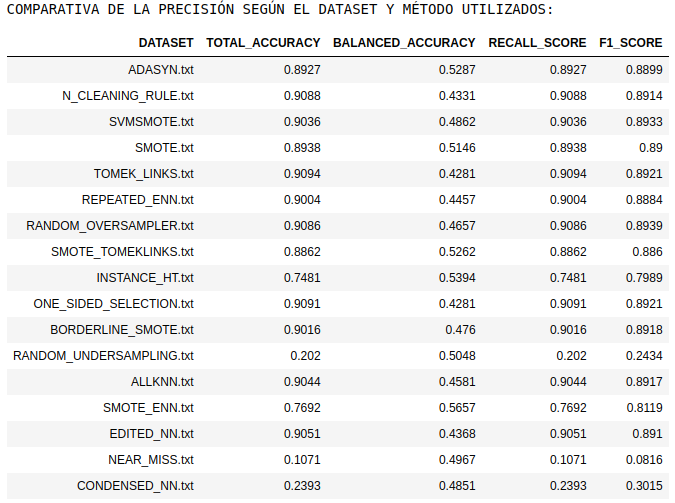

Como podemos ver, los sistemas de resampling que dan una precisión por encima del 52% son, por importancia decreciente:
                       ALGORITMO                                         BALAN_ACC    RECALL      F1
    1. SMOTE + Edited Nearest Neighbours (Ovesampling + Undersampling):   56,57%      76,92%     81,19%
    2. Instance Hardness Threshold (Undersampling):                       53,94%      74,81%     79,89%
    3. ADASYN (Oversampling):                                             52,87%      89,27%     88,99%
    4. SMOTE + TomekLinks (Ovesampling + Undersampling):                  52,62%      88,62%     88,60%
    
En principio, podría parecer que SMOTE + Edited Nearest Neighbours (Ovesampling + Undersampling) es el mejor sistema de resampleado según la precisión balanceada pero según la métrica de Recall y F1, nos decantaríamos más por ADASYN o SMOTE + TomekLinks (Ovesampling + Undersampling), dado que tienen menos porcentaje de Falsos Positivos y Negativos.

### 3.2. Generación y guardado del mejor resampleado

Dado que los dos mejores algoritmos de resampling han resultado ser SMOTE + TomekLinks (Ovesampling + Undersampling) y ADASYN (Oversampling), elegiremos como algoritmo de resampleado SMOTE + Tomeklinks debido a que no solo genera muestras sintéticas sino que limpia las muestras originales reiterativas (ya que es una estrategia combinada de sub/sobre muestreo), no como ADASYN que solo crea muestras sinteticas.

Ejecutamos otra vez la función pero esta vez, solamente generamos un fichero .txt resampleado mediante la estrategia **SMOTE + TomekLinks**:

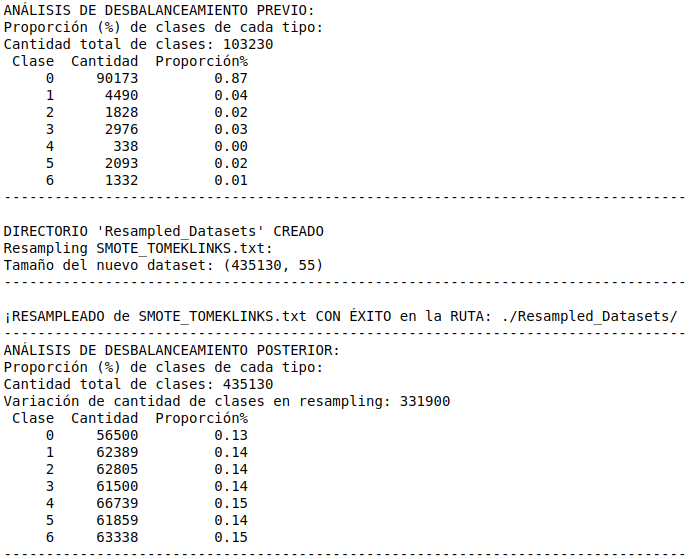

El algortimo ha reducido el numero de muestras de viviendas casi a la mitad y ha incrementado el numero de muestras de las demás clases para balancear el dataset al nuvel de la clase mayoritaria.
Ahora a nuestro algoritmo de machine learning le costará mucho menos aprender los patrones de las clases minoritarias, lo cual incrementará la precisión global en la clasificación de fincas.

Cargamos el archivo SMOTE_TOMEKLNKS.txt generado, para proceder al entreno de los modelos e instanciamos las variables para ello 'resampled_X'(que funcionará de X_train), 'resampled_y'(que funcionará de y_train).
Adicionalmente cargamos las variables 'X_test' e 'y_test' que habíamos guardado en 'Validation_New_Data_UH2020.txt', procedentes del split del dataset enriquecido con variables nuevas que se usó para generar dataset resampleado de enteno:

In [31]:
#Directorios de uso:
RESAMPLED_DIRECTORY= './Resampled_Datasets/'
RESAMPLED_FILE_NAME = 'SMOTE_TOMEKLINKS.txt'
PATH = './Datasets/'
VALIDATION_FILE_NAME = 'Validation_New_Data_UH2020.txt'

#Datasets de entreno y validación
resampled_data = pd.read_csv(RESAMPLED_DIRECTORY + RESAMPLED_FILE_NAME, sep='|') #Entreno
validation_data = pd.read_csv(PATH + VALIDATION_FILE_NAME, sep='|')              #Validación

#Instanciación de las variables de entreno
X_train = resampled_data.iloc[:,1:-1]
y_train = resampled_data.iloc[:, -1:]
#Instanciación de las variables de validación
X_test = validation_data.iloc[:,:-1]
y_test = validation_data.iloc[:, -1:]

print('Comprobamos las dimensiones post-split del modelo:')
print('X_train:',X_train.shape)
print('X_test: ',X_test.shape)
print('y_train:',y_train.shape)
print('y_test: ',y_test.shape)

Comprobamos las dimensiones post-split del modelo:
X_train: (428418, 24)
X_test:  (25808, 24)
y_train: (428418, 1)
y_test:  (25808, 1)


## 4. Construcción, entreno del modelo

### 4.1 Selección de modelos

#### 4.1.a Random Forest

In [32]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 30, 
                            max_features = 7, criterion = 'entropy',
                            random_state = 2020, verbose =1, n_jobs=-1)

y_pred = rf.fit(X_train, y_train).predict(X_test)

print('')
print('Exactitud (accuracy): {}'.format(np.round(accuracy_score(y_test, y_pred),4)))
print('Exactitud balanceada: {}'.format(np.round(balanced_accuracy_score(y_test, y_pred),4)))
print('F1 medio:             {}'.format(np.round(f1_score(y_test, y_pred, average='weighted'),4)))
print('Precisión medio:      {}'.format(np.round(precision_score(y_test, y_pred, average='weighted'),4)))
print('Recall medio:         {}'.format(np.round(recall_score(y_test, y_pred, average='weighted'),4)))
print('Jaccard Score medio:  {}'.format(np.round(jaccard_score(y_test, y_pred, average='weighted'),4)))
print('F1 por clase:         {}'.format(np.round(f1_score(y_test, y_pred, average=None),4)))
print('Precisión por clase:  {}'.format(np.round(precision_score(y_test, y_pred, average=None),4)))
print('Recall por clase:     {}'.format(np.round(recall_score(y_test, y_pred, average=None),4)))
print('Jaccard Score:        {}'.format(np.round(jaccard_score(y_test, y_pred, average=None),4)))
print('')
print('-------------MATRIZ DE CONFUSIÓN------------')
conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
print(conf_matrix)
print('--------------------------------------------')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   54.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.3s finished



Exactitud (accuracy): 0.8906
Exactitud balanceada: 0.5682
F1 medio:             0.8918
Precisión medio:      0.8938
Recall medio:         0.8906
Jaccard Score medio:  0.8357
F1 por clase:         [0.9527 0.6714 0.2742 0.3651 0.7356 0.3168 0.4814]
Precisión por clase:  [0.9562 0.662  0.2716 0.3376 0.6531 0.3683 0.4263]
Recall por clase:     [0.9491 0.681  0.2768 0.3976 0.8421 0.278  0.5529]
Jaccard Score:        [0.9096 0.5053 0.1589 0.2233 0.5818 0.1882 0.317 ]

-------------MATRIZ DE CONFUSIÓN------------
[[21407   176   218   420    17   173   144]
 [  207   760    65    29     8    24    23]
 [  159   102   129    47     1    16    12]
 [  295    29    29   293     4    26    61]
 [    3     7     0     2    64     0     0]
 [  239    53    29    37     3   144    13]
 [   77    21     5    40     1     8   188]]
--------------------------------------------


#### 4.1.b Gradient Boosting Classifier

In [ ]:
gbc = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.2, loss='deviance', max_depth=4,
                           max_features=4, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=250,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=2020, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=1,
                           warm_start=False)

y_pred = gbc.fit(X_train, y_train).predict(X_test)

print('')
print('Exactitud (accuracy): {}'.format(np.round(accuracy_score(y_test, y_pred),4)))
print('Exactitud balanceada: {}'.format(np.round(balanced_accuracy_score(y_test, y_pred),4)))
print('F1 medio:             {}'.format(np.round(f1_score(y_test, y_pred, average='weighted'),4)))
print('Precisión medio:      {}'.format(np.round(precision_score(y_test, y_pred, average='weighted'),4)))
print('Recall medio:         {}'.format(np.round(recall_score(y_test, y_pred, average='weighted'),4)))
print('Jaccard Score medio:  {}'.format(np.round(jaccard_score(y_test, y_pred, average='weighted'),4)))
print('F1 por clase:         {}'.format(np.round(f1_score(y_test, y_pred, average=None),4)))
print('Precisión por clase:  {}'.format(np.round(precision_score(y_test, y_pred, average=None),4)))
print('Recall por clase:     {}'.format(np.round(recall_score(y_test, y_pred, average=None),4)))
print('Jaccard Score:        {}'.format(np.round(jaccard_score(y_test, y_pred, average=None),4)))
print('')
print('-------------MATRIZ DE CONFUSIÓN------------')
conf_matrix = confusion_matrix(y_test, y_pred, labels=None, sample_weight=None, normalize=None)
print(conf_matrix)
print('--------------------------------------------')

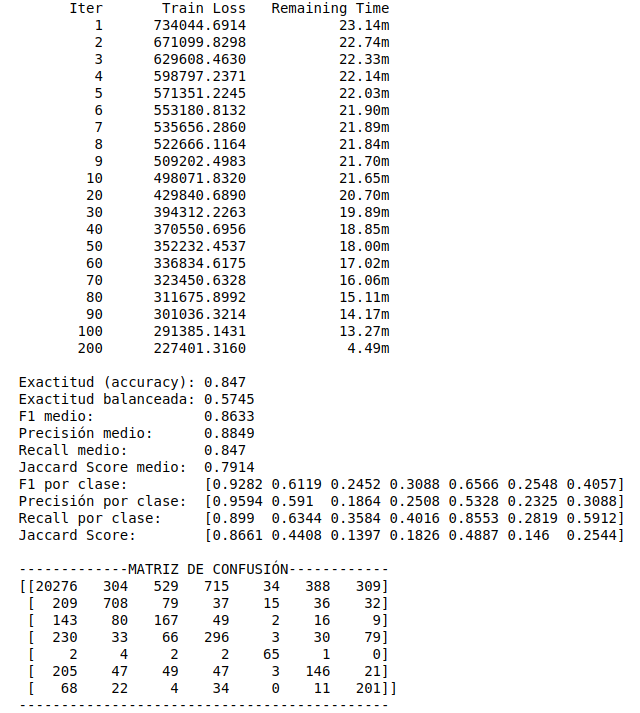

#### 4.1.c Modelo definitivo: Random Forest con tunning custom:

El mejor tunning de parámetros que obtenemos, con el que conseguimos el mejor modelo, el siguiente:

In [35]:
X_total = X_train
X_total = X_total.append(X_test)
y_total = y_train
y_total = y_total.append(y_test)

In [36]:
rf = RandomForestClassifier(n_estimators = 200, max_depth = 30, 
                            max_features = 7, criterion = 'entropy',
                            random_state = 2020, verbose =1, n_jobs=-1) 


rf_model1 = rf.fit(X_total, y_total)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.8min finished


#### Guardado del mejor modelo entrenado para proceder a clasificar:

In [ ]:
#TRAINED_MODEL_NAME = 'Trained_Classifier_rf.pkl'
#joblib.dump(rf_model1, TRAINED_MODEL_NAME)

## 6. Script de clasificación

### 6.1. Construcción de la arquitectura del clasificador

#### Carga del Input ('Estimar_UH2020.txt'):

In [37]:
#Rutas que definimos:
TEST_FILE_NAME = 'Estimar_UH2020.txt'
PATH = './Datasets/'

#Carga de los ficheros de entreno:
data_test = pd.read_csv(PATH + TEST_FILE_NAME, sep='|')

#### Transformaciones del dataset

In [38]:
#Desmenuzamos
id_data = data_test.iloc[:,0] 
x_y_data = data_test.iloc[:,1:3] 
rgb_data = data_test.iloc[:,3:36] 
nir_data = data_test.iloc[:,36:47]
polygon_data = data_test.iloc[:,[47,48,49,50,51]]
environment_data = data_test.iloc[:,[52,53,54]]

In [39]:
#Escalamos
red_data = rgb_data.iloc[:,:11]
green_data = rgb_data.iloc[:,11:22]
blue_data = rgb_data.iloc[:,22:33]
red_data = (red_data - red_data.mean()) / red_data.std()
green_data = (green_data - green_data.mean()) / green_data.std()
blue_data = (blue_data - blue_data.mean()) / blue_data.std()
rgb_data = pd.concat([red_data, green_data], axis = 1,)
rgb_data = pd.concat([rgb_data, blue_data], axis = 1,)
nir_data = (nir_data - nir_data.mean()) / nir_data.std()

In [40]:
#Limpiamos
environment_data.loc[:,'MAXBUILDINGFLOOR'] = environment_data['MAXBUILDINGFLOOR'].fillna(0)
environment_data.loc[:,'CADASTRALQUALITYID'] = environment_data['CADASTRALQUALITYID'].fillna('0')
environment_data.loc[:,'CONTRUCTIONYEAR'] = environment_data['CONTRUCTIONYEAR'].max() - environment_data['CONTRUCTIONYEAR']
environment_data.loc[:,'CADASTRALQUALITYID'] = environment_data['CADASTRALQUALITYID'].replace({"A": '1', "B": '2', "C": '3', 1: '4', 2: '5', 3: '6', 4: '7', 5: '8', 6: '9', 7: '10', 8: '11', 9: '12'}).astype(np.int64)


/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [41]:
#Creamos las variables de enriquecimiento del dataset
random_state = 2020
X_list = [x_y_data.to_numpy()]
i = 1
for ds_cnt, X_Y in enumerate(X_list):
    i += 1
discretizer = KBinsDiscretizer(n_bins=50, encode='ordinal', strategy='uniform')
transformed_X_Y = pd.DataFrame(discretizer.fit_transform(X_Y), columns=['X_discr', 'Y_discr'])
X_Y_location = []
for coord in transformed_X_Y.values:
    position = str(int(coord[0]))+str(int(coord[1]))
    X_Y_location.append(position)
transformed_X_Y_location = pd.DataFrame(X_Y_location, columns=['X_Y_quadrant'])
le = LabelEncoder()
le.fit(X_Y_location)
quadrant_num_data = pd.DataFrame(le.transform(X_Y_location), columns=['Quadrant_num'])

escalador = StandardScaler()
rgb_nir_data = pd.concat([rgb_data, nir_data], axis = 1,)
escalador.fit(rgb_nir_data)
X_escalado = escalador.transform(rgb_nir_data)
pca = PCA(.99)
pca.fit(X_escalado)
X_pca = pca.transform(X_escalado)
n_components = X_pca.shape[1]
pca_data = pd.DataFrame(X_pca)

In [42]:
#Reconstruimos
data = id_data
data = pd.concat([data, x_y_data], axis = 1,)
data = pd.concat([data, quadrant_num_data], axis = 1,)
data = pd.concat([data, pca_data], axis = 1,)
data = pd.concat([data, polygon_data], axis = 1,)
data = pd.concat([data, environment_data], axis = 1,)

In [43]:
#Instanciamos las variables
X_test = data.iloc[:,1:]
y_pred = rf_model1.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   57.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  4.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    0.1s finished


### 6.2. Generación del dataset de test


Creamos las variables del DataFrame final 'result_df':

In [44]:
result_df = pd.DataFrame()
result_df['ID'] = data.iloc[:,0]
result_df['CLASE'] = pd.DataFrame(y_pred).replace({0:"RESIDENTIAL",
                                     1:"INDUSTRIAL", 
                                     2:"OFFICE", 
                                     3:"PUBLIC", 
                                     4:"AGRICULTURE", 
                                     5:"RETAIL", 
                                     6:"OTHER"})

Guardamos la columna 'ID' y la columna 'CLASE' con la clase predicha por nuestro modelo en el fichero 'L2B2_UH2020.txt':

In [45]:
OUTPUT_FILE_NAME = 'L2B2_UH2020.txt'
PATH = './'
result_df.to_csv(PATH + OUTPUT_FILE_NAME, sep='|', index_label=False)

print('¡Archivo ' + OUTPUT_FILE_NAME + ' generado correctamente!')
print('Tiene un tamaño de {} filas y {} columnas'.format(result_df.shape[0], result_df.shape[1]))
print(result_df)

¡Archivo L2B2_UH2020.txt generado correctamente!
Tiene un tamaño de 5618 filas y 2 columnas
                    ID        CLASE
0     44198C2A811A4DF4        OTHER
1     216F638609E0E39E       OFFICE
2     FFFCEFB11E257364  RESIDENTIAL
3       596C5C8CE10BCF       PUBLIC
4     F931B9FA2A8641D1   INDUSTRIAL
...                ...          ...
5613  EEDC412322324F11  RESIDENTIAL
5614  C3ED06EF07E7B00D  RESIDENTIAL
5615  C9625D1602A319E5  RESIDENTIAL
5616  3A42595E9285B866       OFFICE
5617  09E10CFCA9CD293B  RESIDENTIAL

[5618 rows x 2 columns]


In [8]:
#Datos que definimos:
TRAIN_FILE_NAME = '/UIB/_L2B2.txt'
PATH = './'

#Carga de los ficheros de entreno:
data_train = pd.read_csv(PATH + TRAIN_FILE_NAME, sep='|')


FileNotFoundError: [Errno 2] File b'.//UIB/_L2B2.txt' does not exist: b'.//UIB/_L2B2.txt'

## 7. Retos futuros

En el caso de que pasaramos la primera fase, tenemos previsto implementar:

- Otros sistemas de resampling que han ido apareciendo en los últimos papers académicos: SOUP, MDO, ECOC, Roughly Balanced Bagging, SPIDER3
- Tratar variables RGB y NIR mediante redes neuronales convulocionales unidimensionales optimizadas y paralelas para ser añadida al dataset como variable extra.
- Diseñar nuevas variables sintéticas que puedan enriquecer el Dataset.
- Ampliar los modelos incluidos en el "Stacking" final: Xgboost, entre otros.